In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [20]:
import glob
import warnings
import numpy as np
import pylab as plt

from skimage import morphology
from scipy.ndimage import binary_dilation

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip
from astropy.convolution import Gaussian2DKernel, convolve

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from rotate import shiftRotateXYZ
from parabolas import loadLeicaData, fitLeicaData, parabola
from grid import regridXYZ, regridXYZMasked
from zernikies import getZernikeCoeffs, zernikePoly
from utils.utils import midPoint, gridLimits, maskDiff
from analyzeActiveSurface import processActiveSurfaceFITSPair
from analysis.March2020.zernike import make_aperture_efficiency, aperture_efficiency_residuals

In [14]:
def parabolaFitIterations(x, y, z, guess=[60., 0, 0, -50., 0, 0], bounds=None, iters=2, 
                          max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-4):
    
    mask = np.isnan(z)
    
    for i in range(iters):
        
        x_ = np.ma.masked_where(mask, x)
        y_ = np.ma.masked_where(mask, y)
        z_ = np.ma.masked_where(mask, z)
        
        fit = fitLeicaData(x_.compressed(), y_.compressed(), z_.compressed(), 
                           guess, bounds=bounds, f_scale=f_scale, ftol=ftol, 
                           xtol=xtol, max_nfev=max_nfev)
        
        xdr, ydr, zdr = alignXYZ(x, y, z, fit.x)
        
        zp = parabola(xdr, ydr, fit.x[0])
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = sigma_clip(zdr - zp)
        mask = binary_dilation(res.mask, iterations=2)
        guess = fit.x
    
    return fit, mask

def prepareData(filename, n=512, rot=178.):
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    xg, yg, zg = regridXYZ(x, y, z, n=n)
    xg, yg, zg = shiftRotateXYZ(xg, yg, zg, [0, 0, 0, 0, 0, np.deg2rad(rot)])
    
    return xg, yg, zg

def maskLoop(diff):
    mask = maskDiff(diff, window=(20,20), threshold=2)
    mDiff = np.ma.masked_where(mask, diff)
    b = morphology.remove_small_holes(mDiff.mask, area_threshold=64)
    mDiff = np.ma.masked_where(b, mDiff)
    return mDiff

def maskData(diff):
    mDiff = maskLoop(diff)
    #mDiff = np.ma.masked_outside(mDiff, -5e-3, 5e-3)
    mDiff = maskLoop(diff)
    return mDiff

def alignXYZ(x, y, z, fit):
    cor = np.hstack((-1*fit[1:4],fit[4:6],0))
    xr, yr, zr = shiftRotateXYZ(x, y, z, cor)
    return xr, yr, zr

In [15]:
n = 512
rot = 179.5
nZern = 36
guess = [6.00319194e+01, 2.45282692e+00, -9.96895755e-01, -4.92e+01, 2.19838173e-01, -5.05770158e-03]
kernel = Gaussian2DKernel(x_stddev=17.)
maskIters = 3
inf = np.inf
pi2 = 2*np.pi
b1 = [59., -inf, -inf, -49.2-1e-4, -pi2, -pi2]
b2 = [61.,  inf,  inf, -49.2+1e-4,  pi2,  pi2]
bounds = (b1, b2)
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'

In [16]:
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
xr, yr, zr = prepareData(refScan, n=n, rot=rot)

In [23]:
zrgs = convolve(zr, kernel, boundary='extend', fill_value=0.0, nan_treatment='interpolate', 
                normalize_kernel=True, mask=None, preserve_nan=True, normalization_zero_tol=1e-08)
zrsFit, zrsMask = parabolaFitIterations(xr, yr, zrgs,
                                        guess=guess, bounds=bounds, iters=10, 
                                        max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-5)
pFitR = np.copy(zrsFit.x)
xra, yra, zra = alignXYZ(xr, yr, zr, pFitR)

In [24]:
%%time

# Use the .zernike.fits files to select signal scans.
fitsDir = '/home/gbtdata/TLASSI_200315'
zern_files = natsorted(glob.glob("{0}/LASSI/*.zernike.fits".format(fitsDir)))[3:]

zFitDict = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i,ff in enumerate(zern_files):
        
        time = Time( '{0}T{1}'.format('-'.join(ff.split('/')[-1].split('.')[0].split("_")[:3]), 
                                  ff.split('/')[-1].split('.')[0].split("_")[-1]) )
        mjd = time.mjd

        sf = ff.replace(".zernike.fits", ".fits")
        sigScanFile = "{0}/{1}".format(scanDir, sf.split('/')[-1].replace('.fits', '.ptx.csv'))

        # Find the scan number.
        hdu = fits.open(sf)
        head = hdu[0].header
        scan = head['SCAN']

        xs, ys, zs = prepareData(sigScanFile, n=n, rot=rot)
        
        zsgs = convolve(zs, kernel, boundary='extend', fill_value=0.0, nan_treatment='interpolate', 
                normalize_kernel=True, mask=None, preserve_nan=True, normalization_zero_tol=1e-08)
        zssFit, zssMask = parabolaFitIterations(xs, ys, zsgs,
                                                guess=guess, bounds=bounds, iters=10, 
                                                max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-5)
        pFitS = np.copy(zssFit.x)
        xsa, ysa, zsa = alignXYZ(xs, ys, zs, pFitS)
        
        
        xmin, xmax = gridLimits(xsa, xra)
        ymin, ymax = gridLimits(ysa, yra)
        xrag, yrag, zrag = regridXYZ(xra, yra, zra, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
        xsag, ysag, zsag = regridXYZ(xsa, ysa, zsa, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
        
        # Start masking.
        diff = np.ma.masked_invalid(zsag - zrag)
        diff = sigma_clip(diff, 10)
        
        mDiff0 = maskData(diff)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            for i in range(maskIters):
                mDiff0 = maskData(mDiff0)
        mDiff0_ = sigma_clip(mDiff0, 5)
        
        fl_fs = getZernikeCoeffs(mDiff0_.filled(0)[::-1].T, nZern, norm='active-surface')
        
        diff_ = np.ma.copy(mDiff0_)
        fl_fs_sub = np.copy(fl_fs)
        it = 0
        while np.any(abs(fl_fs_sub[2:4]) > 50e-6):
            #fl_fs_sub[1] *= 0.
            fl_fs_sub[2] *= -1.
            zpoly_ = zernikePoly(xrag, yrag, midPoint(xrag), midPoint(yrag), fl_fs_sub[0:4])
            diff_ = diff_ - zpoly_
            fl_fs_sub = getZernikeCoeffs(diff_.filled(0)[::-1].T, 36, norm='active-surface')
            it += 1
        
        zFitDict[scan] = {'recovered zernike': fl_fs,
                          'recovered zernike tilt subtracted': fl_fs_sub,
                          'mjd': mjd
                         }

CPU times: user 1h 28min 25s, sys: 1h 11min 13s, total: 2h 39min 38s
Wall time: 22min 28s


In [25]:
%%time

asDict = {}

# Use the .zernike.fits files to select signal scans.
zern_files = natsorted(glob.glob("{0}/LASSI/*.zernike.fits".format(fitsDir)))[3:]

# Load the ScanLog
hdu = fits.open("{0}/ScanLog.fits".format(fitsDir))
scanArr = hdu[1].data

for i, zf in enumerate(zern_files):
    
    hdu = fits.open(zf)
    head = hdu[0].header
    scan = head['MC_SCAN']

    idx = np.where(scanArr['SCAN'] == scan)[0][0]
    idx_as = idx - 3
    sig_scan = scanArr['SCAN'][idx_as]
    ref_scan = scanArr['SCAN'][idx_as-6]

    # Load the AS fits file for the signal scan.
    as_file = file = '/'.join(scanArr[idx_as]['FILEPATH'].split('/')[-2:])
    hdu = fits.open("{0}/{1}".format(fitsDir, as_file))
    z_as = hdu[1].data['value']

    # The AS Zernike contents start at Z1, not Z0.
    # The LASSI Zernike start at Z0.
    z_idx = int(np.where(z_as != 0)[0])

    as_file_sig = '/'.join(scanArr[idx_as]['FILEPATH'].split('/')[-2:])
    as_file_ref = '/'.join(scanArr[idx_as - 6]['FILEPATH'].split('/')[-2:])
    #print(as_file_sig, as_file_ref)
    xas, yas, aas, aar, fitlist = processActiveSurfaceFITSPair("{0}/{1}".format(fitsDir, as_file_ref), 
                                                               "{0}/{1}".format(fitsDir, as_file_sig), 
                                                               column='ABSOLUTE', filterDisabled=True, 
                                                               verbose=False, plot=False)
    z_as_obs = fitlist

    z_in = z_as[z_idx]
    z_in_as = z_as_obs[z_idx+1]*1e6 # microns

    asDict[scan] = {'input zernike': z_idx + 1,
                    'input zernike value': z_as[z_idx],
                    'active surface zernike value': z_in_as,
                    'active surface reference scan': ref_scan,
                    'active surface signal scan': sig_scan,
                     }

CPU times: user 33.6 s, sys: 2.98 s, total: 36.6 s
Wall time: 31.1 s


In [26]:
%%time
zindxs = [4, 7, 13]
zcoefs = np.arange(0., 500., 10.)*1e-6 # m
eps_tot, eta_tot = make_aperture_efficiency(zindxs, zcoefs, n=256, eps=225e-6)

CPU times: user 44.6 s, sys: 35.4 ms, total: 44.7 s
Wall time: 44.7 s


In [27]:
%%time

zin = np.zeros(len(zern_files), dtype=np.float)
mjds = np.zeros(len(zern_files), dtype=np.float)
zobs = np.zeros((len(zern_files),4), dtype=np.float)
zinval = np.zeros(len(zern_files), dtype=np.float)
residuals = np.zeros((len(zern_files),2), dtype=np.float)

for i,k in enumerate(natsorted(list(zFitDict.keys()))):
    
    zi = asDict[k]['input zernike']
    ci = asDict[k]['active surface zernike value']
    if zi == 7:
        ci *= -1
    ci_obs = zFitDict[k]['recovered zernike'][zi]
    ci_obs_ = zFitDict[k]['recovered zernike tilt subtracted'][zi]
    #ci_obs_m = zFitDict[k]['recovered zernike masked'][zi]
    #ci_obs_m_ts = zFitDict[k]['recovered zernike masked tilt subtracted'][zi]
    #ci_obs_ls = zFitDict[k]['recovered zernike LS'][zi]
    #if zi == 7:
    #    ci_obs_ls *= -1
    mjds[i] = zFitDict[k]['mjd']
    
    zin[i] = zi
    zinval[i] = ci
    zobs[i,0] = ci_obs
    zobs[i,1] = ci_obs_
    #zobs[i,2] = ci_obs_m
    #zobs[i,3] = ci_obs_m_ts
    #zobs[i,2] = ci_obs_ls
    residuals[i,0] = abs(ci - ci_obs)
    residuals[i,1] = abs(ci - ci_obs_)

CPU times: user 461 µs, sys: 370 µs, total: 831 µs
Wall time: 840 µs


In [28]:
time = Time(mjds, format='mjd')
eta_res_0 = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs[:,0]*1e6)
eta_res_1 = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs[:,1]*1e6)
eta_res_2 = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs[:,2]*1e6)
eta_res_3 = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs[:,3]*1e6)
eta_res_comb = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs.mean(axis=1)*1e6)

In [29]:
#np.savetxt("March2020_Ci_in_out_no_align.txt", np.c_[mjds, zin, zinval, zobs[:,1]*1e6, eta_res_1])

<IPython.core.display.Javascript object>


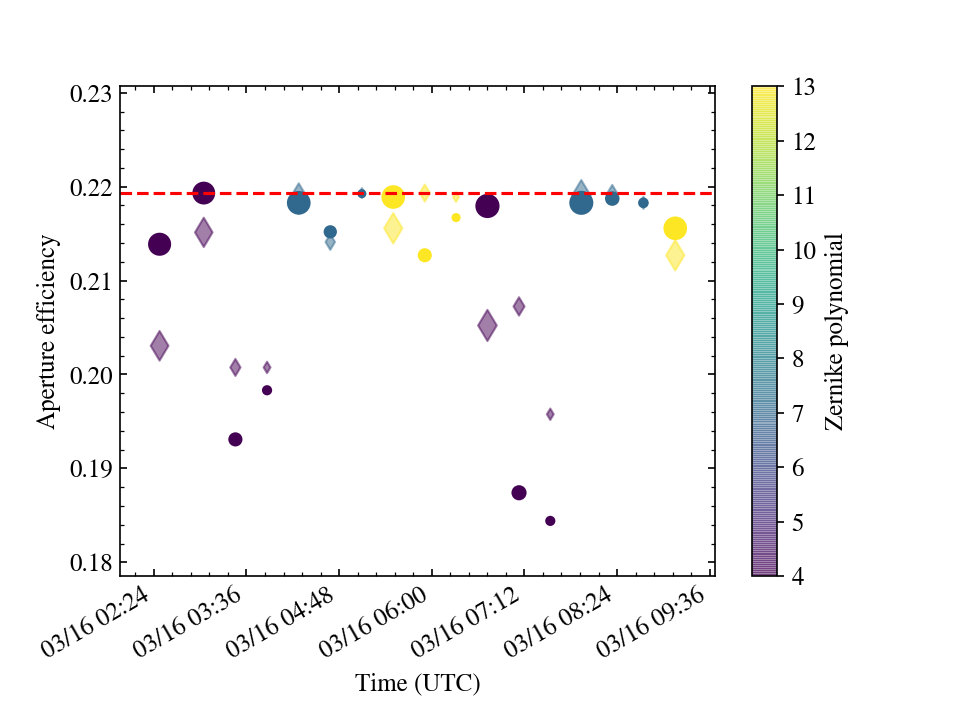

In [34]:
from matplotlib.dates import DateFormatter
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('font', **{'family':'STIXGeneral', 'weight':'normal'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams.update({'font.size': 12})

formatter = DateFormatter('%m/%d %H:%M')

fig = plt.figure(dpi=150, frameon=False)

ax = fig.add_subplot(111)
#axt = ax.twiny()

ax.axhline(y=np.max(eta_tot), color='r', linestyle='--')
sc = ax.scatter(time.plot_date, eta_res_0, c=zin, s=abs(zinval)/5., marker='o')
sc = ax.scatter(time.plot_date, eta_res_1, c=zin, s=abs(zinval)/5., marker='d', alpha=0.5)
#sc = ax.scatter(time.plot_date, eta_res_2, c=zin, s=abs(zinval)/5., marker='.', alpha=0.5)
#sc = ax.scatter(time.plot_date, eta_res_3, c=zin, s=abs(zinval)/5., marker='s')
cb = plt.colorbar(sc)
cb.set_label('Zernike polynomial')
ax.minorticks_on()
ax.tick_params('both', direction='in', which='both', top=True, right=True, left=True, bottom=True)
#ax.set_xlabel("Scan")
ax.set_ylabel("Aperture efficiency")

ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Time (UTC)')

fig.autofmt_xdate()


#plt.savefig("eta_scan_avgrefsimple.pdf", bbox_inches='tight', pad_inches=0.06)

In [45]:
idx = -5
print(zin[idx], zinval[idx], zobs[idx]*1e6, zobs[idx].mean()*1e6)

4.0 -75.19745118683095 [-282.48855282 -242.56559833    0.            0.        ] -131.26353778668826


In [32]:
print(np.max(eta_tot), np.mean(eta_res_0), np.power(np.mean(eta_res_0)/np.max(eta_tot), -2.))

0.21932075789662847 0.2109568891473417 1.0808664855124446


In [33]:
print(np.max(eta_tot), np.mean(eta_res_1), np.power(np.mean(eta_res_1)/np.max(eta_tot), -2.))

0.21932075789662847 0.21195204670236542 1.070740541364102


In [65]:
print(np.max(eta_tot), np.mean(eta_res_2), np.power(np.mean(eta_res_2)/np.max(eta_tot), -2.))

0.20804304085861067 0.20343253748921505 1.045840735336169


In [66]:
print(np.max(eta_tot), np.mean(eta_res_3), np.power(np.mean(eta_res_3)/np.max(eta_tot), -2.))

0.20804304085861067 0.20337350457133713 1.0464479726537326


In [109]:
print(np.max(eta_tot), np.mean(eta_res_comb), np.power(np.mean(eta_res_comb)/np.max(eta_tot), -2.))
erc = np.hstack((eta_res_comb[:7],eta_res_comb[8:]))
print(np.max(eta_tot), np.mean(erc), np.power(np.mean(erc)/np.max(eta_tot), -2.))

0.20804304085861067 0.2003316218338315 1.0784682699275414
0.20804304085861067 0.20408915855011467 1.0391219428654044


In [51]:
60*1.05

63.0

In [46]:
zern_files[-5]

'/home/gbtdata/TLASSI_200315/LASSI/2020_03_16_07:32:07.zernike.fits'

In [101]:
list(zFitDict.keys())[10]

81

In [103]:
asDict[81]

{'input zernike': 4,
 'input zernike value': 500.0,
 'active surface zernike value': -552.0855717303331,
 'active surface reference scan': 78,
 'active surface signal scan': 80,
 'mjd': 58924.28005787037}